<a href="https://colab.research.google.com/github/jhkang0516/dialect_classification/blob/main/PreprocessingV03_%ED%91%9C%EC%A4%80%EC%96%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/TeamProject/'

/content/drive/MyDrive/Colab Notebooks/TeamProject


In [ ]:
!pip install noisereduce

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import sklearn
from sklearn.preprocessing import MinMaxScaler
from scipy.io import wavfile
import noisereduce as nr

import warnings  # 경고 제거
warnings.filterwarnings(action='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib.cm import datad
import time
import json

wavDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/wav2/"
wavDenoiseDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/wavdn3/"

metaDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/"
metadataFileName = "broadcast_02_metadata.txt"
mataLocation = metaDir + metadataFileName

f = open(mataLocation, 'r')

X_mfcc = []
# X_subdata = []
Y_label = []

nums = 0
numM = 0
numF = 0
nowprocess_num = 0
numFolder = [0] * 100
flipCounter = True

start_codetime = time.time()
print("Processing 10000 files started")

for line in f:
    line = line.strip()
    terms = line.split(' | ')
    if int(terms[0].split('/')[0]) > 20: break
    if ((terms[8] == '1') * (terms[6] == '1') * (terms[5] == '1')):
      if (((terms[3] == 'M') * (numM < (5000-5000))) + ((terms[3] == 'F') * (numF < (5000-3710)))):
        if (numFolder[int(terms[0].split('/')[0]) - 1] < 1000):
            if numFolder[int(terms[0].split('/')[0]) - 1] == 1:
                print("Now processing " + terms[0].split('/')[0] + "%", "[ 경과시간: {:>.6} ]".format(time.time()-start_codetime))

            wavFile = terms[0]

            if wavFile.endswith(".wav"):
                if wavFile.count(".") == 1:
                    jsonFile = wavFile.split('.')[0]
                    jsonID = jsonFile
                    # print("Now processing with " + jsonFile, "(", nowprocess_num, "/ 10000 )", "[ 경과시간: {:>.4} ]".format(time.time()-start_codetime))
                    jsonFile += '.json'

            # flipCounter = !flipCounter
            # if flipCounter == False: continue

            jsonLocation = wavDir + jsonFile
            try:
                with open(jsonLocation) as file:
                    data = json.load(file)
            except FileNotFoundError:
                # print("File not found: " + jsonFile)
                continue
            except json.JSONDecodeError:
                try:
                    with open(jsonLocation, encoding='UTF-8-sig') as file:
                        data = json.load(file)
                except:
                    print("Error occurs while decoding JSON: " + jsonFile)
                    continue

            # JSON 파일 처리 jsonFile
            start_utter = data.get("start")
            end_utter = data.get("end")
            time_utter = data.get("length")

            # 문장이 너무 짧으면 스킵(2초 미만)
            if time_utter < 2:
                continue

            ############# 노이즈 제거 부분 ##########
            wavfileLocation = wavDir + wavFile
            rate, wdata = wavfile.read(wavfileLocation);
            reduced_noise = nr.reduce_noise(y=wdata, sr=25500);
            # wavfile.write("노이즈 제거.wav", rate, reduced_noise);
            #####################################

            ############ 정규화 과정 ###############
            # 정규화 수식
            def mu_law(x, mu=255):
              return np.sign(x) * np.log(1+mu*np.abs(x))/np.log(1+mu)

            # 정규화
            x = np.linspace(-1,1,1000)
            x_mu = mu_law(x)

            # 정규화
            norm_wav = reduced_noise / np.max(np.abs(reduced_noise))

            # 정규화된 데이터를 정수형으로 변환
            norm_wav_int = np.int16(norm_wav * 32767)

            # 정규화된 WAV 파일 저장(파괴적 저장/기존 파일 백업 필요)
            wavdnfileLocation = wavDenoiseDir + wavFile
            wavfile.write(wavdnfileLocation, rate, norm_wav_int)
            ####################################

            # MFCC 추출을 위한 파일 로드
            wavLocation = wavDenoiseDir + wavFile
            y, sr = librosa.load(wavLocation, offset=start_utter, duration=end_utter-start_utter)

            # MFCC 추출
            mfcc = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=40)
            mfcc = mfcc[1:]

            # MFCC 길이 패딩(SpeakUP)
            padding = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
            mfcc_pad = padding(mfcc, 259)

            # 서브데이터와 라벨데이터 관리
            sub_data = [start_utter, end_utter, time_utter]
            label_data = '표준'

            # Dataset에 처리 결과 추가
            X_mfcc.append(mfcc_pad)
            # X_subdata.append(sub_data)
            Y_label.append(label_data)

            # X_mfcc 차원 처리
            # X_mfcc.reshape(-1, mfcc_pad[0].shape, mfcc_pad[1].shape, 1)

            # 현재 처리 완료된 파일 수 변경
            nowprocess_num += 1
            nums += 1
            numFolder[int(terms[0].split('/')[0]) - 1] += 1
            if terms[3] == 'M': numM += 1
            else: numF += 1

# 저장을 위한 numpy array 및 DF 변환
X_mfcc_npy = np.array(X_mfcc)
Y_label_npy = np.array(Y_label)
# X_subdata_DF = pd.DataFrame(X_subdata)

np.save("X_mfcc.npy", X_mfcc_npy)
# X_subdata_DF.to_csv('X_subdata.csv', index=False)
np.save("Y_label.npy", Y_label_npy)

print("Processing finished")

Processing 10000 files started
Now processing 010% [ 경과시간: 0.629315 ]
Now processing 013% [ 경과시간: 602.967 ]
Processing finished


In [ ]:
print(nums, numM, numF)
print(numFolder)

1290 0 1290
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# 출력 데이터 검증용 코드

In [ ]:
Y_test = np.load("Y_label.npy")
X_test = np.load("X_mfcc.npy")

print(X_test.shape)
print(Y_test.shape)

(6439, 39, 259)
(6439,)


In [ ]:
Y_test_DF_t = pd.DataFrame(Y_test)
Y_test_DF_t.head()

,0
0,전라
1,전라
2,전라
3,전라
4,전라


In [ ]:
X_test_DF = pd.DataFrame(X_test[4673]).T
X_test_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


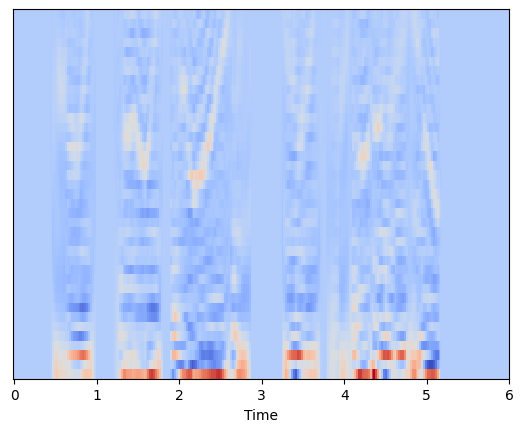

In [ ]:
librosa.display.specshow(X_test[4673], sr=22050, x_axis='time')

In [ ]:
X_testo = np.load("X_mfcc_origin.npy")
X_testo_DF = pd.DataFrame(X_testo[0]).T
X_testo_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,120.656601,30.438766,23.666840,16.843880,20.067898,15.842125,4.757147,-5.412510,-3.827647,6.340557,...,-0.411595,-0.689458,-2.750880,-0.829066,-1.293920,2.326344,8.679650,6.111021,2.447834,-0.760911
1,121.858948,24.084557,29.339233,15.936409,30.105551,20.381845,2.661097,-4.085196,0.552502,7.175173,...,1.186349,2.869191,4.228659,3.260703,0.332719,2.795085,5.203364,6.727644,2.223616,-1.626244
2,118.002655,24.261444,32.378391,18.441246,32.540680,18.567181,5.056997,0.664624,2.602577,12.552938,...,3.945722,1.963007,2.907195,0.971042,3.385482,2.505605,-0.804911,4.381360,1.420428,-1.553347
3,118.546768,25.505472,35.863743,21.837891,30.775707,15.362858,4.588108,3.453425,7.816905,16.421421,...,4.830923,-3.760798,-1.197823,-1.183464,1.796915,4.036798,0.921116,7.552642,2.330337,-0.998921
4,120.989639,26.085567,32.209732,20.723774,32.043060,18.229912,6.960961,4.016418,9.719703,14.380989,...,4.846748,-3.869115,-1.748467,0.493365,3.563256,6.943812,4.429210,6.089929,-1.111485,-2.801223


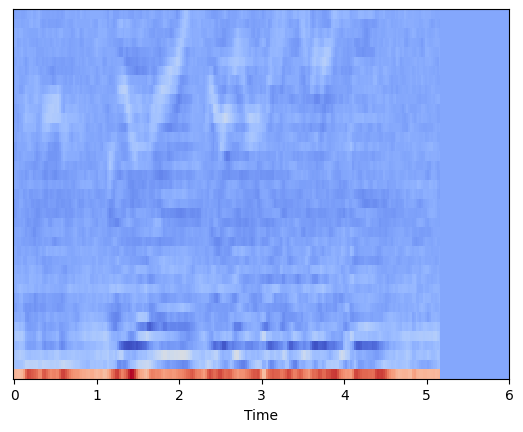

In [ ]:
librosa.display.specshow(X_testo[0], sr=22050, x_axis='time')